# Churn Prediction

## Imports

In [59]:
import os
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                      StratifiedKFold,
                                    GridSearchCV)
import category_encoders as ce
from sklearn.preprocessing import StandardScaler,RobustScaler
from xgboost import (XGBClassifier,
                    plot_importance)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split,
                                      StratifiedKFold,
                                    GridSearchCV)
from sklearn.metrics import (mean_squared_error,
                             confusion_matrix,roc_curve,
                             classification_report,
                             roc_auc_score,
                             accuracy_score,
                             f1_score)

## Notebook Functions

In [8]:
# This function reads a YAML file and returns its contents as a Python Dict.
def load_yaml(ruta_archivo: object) -> object:
    with open(ruta_archivo, 'r') as archivo:
        configuracion = yaml.safe_load(archivo)
    return configuracion

In [9]:
# Get the item from the dict

def get_value(item):
    return item[1]

In [10]:
# Plot confusion matrix and roc side by side

def subplots_ROC_CM(main_title,rtitle,mtitle,mod,accuracy,auc,matrix,model,Xtest,ytest,label):
    fig , axes = plt.subplots(1,2,figsize=(10,8))


    y_pred_prob1_rs = mod.predict_proba(Xtest)[:,1]
    fpr1_rs, tpr1_rs, thresholds1_rs = roc_curve(ytest, y_pred_prob1_rs)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].plot(fpr1_rs, tpr1_rs, label=label)
    axes[0].legend(loc="best")
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(rtitle + "\n" +
             "AUC : {0:.2%}".format(accuracy.get(model)))


    group_counts = ["{0:0.0f}".format(v) for v in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value)
                     for value in matrix.flatten()/np.sum(matrix)]
    labels = [f"{ant1}\n{ant2}" for ant1, ant2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='',
                 cmap='Blues', ax=axes[1])
    axes[1].set_title(mtitle + "\n" + "Accuracy Score: {0:.2%}".format(auc.get(model)))
    axes[1].set_xlabel('\nPredicted Values')
    axes[1].set_ylabel('Actual Values ')
    axes[1].xaxis.set_ticklabels(['False','True'])
    axes[1].yaxis.set_ticklabels(['False','True'])

    plt.suptitle(main_title,size=17, weight='bold')
    plt.show()


## Load Data

In [83]:
data = pd.read_csv(data_path)
data.head()

,state,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
0,KS,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Split the Data

In [84]:
df = data.copy()

In [85]:
X = data.drop(columns=['phone_number','Churn'])
y = data['Churn']
seed = 13

In [100]:
y = y.astype(int)
y

,Churn
0,0
1,0
2,0
3,0
4,0
...,...
4995,0
4996,1
4997,0
4998,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=y)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 18), (1000, 18), (4000,), (1000,))

## Preprocessing Data

In [23]:
cat_cols = list(X.select_dtypes(include=[object]).columns)
cat_cols

['state', 'international_plan', 'voice_mail_plan']

In [24]:
# encode the categorical values
enc = ce.TargetEncoder(cols=cat_cols,smoothing=11).fit(X_train[cat_cols],y_train)
X_train[cat_cols] = enc.transform(X_train[cat_cols])

In [25]:
X_train.head().T

,55,1085,3129,1037,1292
state,0.126652,0.190331,0.147362,0.071636,0.100177
area_code,408.000000,408.000000,510.000000,510.000000,415.000000
international_plan,0.113166,0.113166,0.113166,0.413793,0.113166
voice_mail_plan,0.166610,0.166610,0.072300,0.166610,0.166610
number_vmail_messages,0.000000,0.000000,16.000000,0.000000,0.000000
total_day_minutes,175.500000,252.700000,133.300000,134.200000,221.300000
total_day_calls,67.000000,97.000000,110.000000,80.000000,106.000000
total_day_charge,29.840000,42.960000,22.660000,22.810000,37.620000
total_eve_minutes,249.300000,221.100000,185.700000,165.000000,267.600000
total_eve_calls,85.000000,121.000000,111.000000,71.000000,98.000000


In [26]:
X_test[cat_cols] = enc.transform(X_test[cat_cols])

In [27]:
X_test.head().T

,1208,619,3155,3931,1462
state,0.086300,0.204803,0.099003,0.157274,0.116236
area_code,415.000000,415.000000,408.000000,510.000000,408.000000
international_plan,0.113166,0.413793,0.113166,0.113166,0.113166
voice_mail_plan,0.166610,0.166610,0.166610,0.166610,0.166610
number_vmail_messages,0.000000,0.000000,0.000000,0.000000,0.000000
total_day_minutes,191.400000,293.300000,114.800000,222.400000,199.500000
total_day_calls,93.000000,79.000000,94.000000,90.000000,107.000000
total_day_charge,32.540000,49.860000,19.520000,37.810000,33.920000
total_eve_minutes,205.400000,188.500000,150.000000,286.300000,207.500000
total_eve_calls,119.000000,90.000000,104.000000,104.000000,110.000000


In [28]:
scaler = RobustScaler()

# transform data
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

In [29]:
X_train.head().T

,55,1085,3129,1037,1292
state,-0.193990,0.764513,0.117741,-1.022086,-0.592494
area_code,-7.000000,-7.000000,95.000000,95.000000,0.000000
international_plan,0.000000,0.000000,0.000000,0.300627,0.000000
voice_mail_plan,0.000000,0.000000,-1.000000,0.000000,0.000000
number_vmail_messages,0.000000,0.000000,0.941176,0.000000,0.000000
total_day_minutes,-0.053775,1.010686,-0.635643,-0.623233,0.577732
total_day_calls,-1.307692,-0.153846,0.346154,-0.807692,0.192308
total_day_charge,-0.053517,1.010339,-0.635719,-0.623556,0.577336
total_eve_minutes,0.716827,0.298740,-0.226093,-0.532987,0.988139
total_eve_calls,-0.576923,0.807692,0.423077,-1.115385,-0.076923


In [99]:
# The dataset is unbalanced, target 14.4% of total target
y_train.value_counts(normalize=True)

,proportion
Churn,
0,0.8585
1,0.1415


## Feature Selection

In [31]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

In [35]:
features = XGBClassifier(
    scale_pos_weight = neg / pos,
    eval_metric='logloss',
     random_state=seed
)

features.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

<Figure size 1000x600 with 0 Axes>

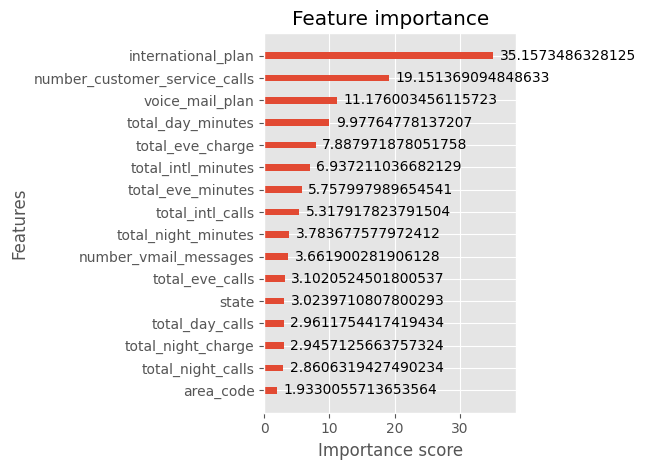

In [36]:
plt.figure(figsize=(10,6))
plot_importance(features,height=0.3,importance_type='gain')
plt.tight_layout()
plt.show()

In [37]:
features_importance_names = features.get_booster().get_score(importance_type='gain')
features_importance_names

{'state': 3.0239710807800293,
 'area_code': 1.9330055713653564,
 'international_plan': 35.1573486328125,
 'voice_mail_plan': 11.176003456115723,
 'number_vmail_messages': 3.661900281906128,
 'total_day_minutes': 9.97764778137207,
 'total_day_calls': 2.9611754417419434,
 'total_eve_minutes': 5.757997989654541,
 'total_eve_calls': 3.1020524501800537,
 'total_eve_charge': 7.887971878051758,
 'total_night_minutes': 3.783677577972412,
 'total_night_calls': 2.8606319427490234,
 'total_night_charge': 2.9457125663757324,
 'total_intl_minutes': 6.937211036682129,
 'total_intl_calls': 5.317917823791504,
 'number_customer_service_calls': 19.151369094848633}

In [38]:
features_importance_names_list = list(features_importance_names.items())
features_importance_names_list.sort(key = get_value,reverse=True)
features_importance_names_list

[('international_plan', 35.1573486328125),
 ('number_customer_service_calls', 19.151369094848633),
 ('voice_mail_plan', 11.176003456115723),
 ('total_day_minutes', 9.97764778137207),
 ('total_eve_charge', 7.887971878051758),
 ('total_intl_minutes', 6.937211036682129),
 ('total_eve_minutes', 5.757997989654541),
 ('total_intl_calls', 5.317917823791504),
 ('total_night_minutes', 3.783677577972412),
 ('number_vmail_messages', 3.661900281906128),
 ('total_eve_calls', 3.1020524501800537),
 ('state', 3.0239710807800293),
 ('total_day_calls', 2.9611754417419434),
 ('total_night_charge', 2.9457125663757324),
 ('total_night_calls', 2.8606319427490234),
 ('area_code', 1.9330055713653564)]

In [39]:
# Get only the first value of the tupple
features_sorted_names = []

for i in features_importance_names_list:
    features_sorted_names.append(i[0])

features_sorted_names

['international_plan',
 'number_customer_service_calls',
 'voice_mail_plan',
 'total_day_minutes',
 'total_eve_charge',
 'total_intl_minutes',
 'total_eve_minutes',
 'total_intl_calls',
 'total_night_minutes',
 'number_vmail_messages',
 'total_eve_calls',
 'state',
 'total_day_calls',
 'total_night_charge',
 'total_night_calls',
 'area_code']

## Model Creation

### Random Forest

In [40]:
rf = RandomForestClassifier(random_state=seed,
                            class_weight='balanced',
                            n_jobs=-1)

In [41]:
# Hyperparameter Tuning
parameters_rf = {
    'n_estimators': [10,100, 200,500],
    'max_depth' : [2, 5, 7,10,20,25],
    'min_samples_split': [12,20,40],
    'criterion':['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [42]:
skfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=seed)

In [43]:
gridRf = GridSearchCV(rf, parameters_rf, cv=skfold)

In [44]:
y_rf_score = gridRf.fit(X_train, y_train)

In [45]:
gridRf.best_score_

np.float64(0.9555001028014521)

In [46]:
# best parameters
gridRf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_split': 12,
 'n_estimators': 500}

In [47]:
best_stimator_grid_rf = gridRf.best_estimator_
best_stimator_grid_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=20, min_samples_split=12,
                       n_estimators=500, random_state=13)

In [49]:
y_rf_pred = gridRf.predict(X_test)

In [50]:
report_rf = classification_report(y_test, y_rf_pred,output_dict=True)
df_report_rf = pd.DataFrame(report_rf).T
df_report_rf

,precision,recall,f1-score,support
0,0.970081,0.981374,0.975694,859.000
1,0.877863,0.815603,0.845588,141.000
accuracy,0.958000,0.958000,0.958000,0.958
macro avg,0.923972,0.898488,0.910641,1000.000
weighted avg,0.957078,0.958000,0.957349,1000.000


In [51]:
#Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_rf_pred)
conf_matrix_rf

array([[843,  16],
       [ 26, 115]])

In [52]:
#Accuracy
acu_rf = accuracy_score(y_test, y_rf_pred)
acu_rf

0.958

In [53]:
#AUC
auc_rf = roc_auc_score(y_test, y_rf_pred)
auc_rf

np.float64(0.8984882636085173)

In [54]:
acmod_rf = {"RF_y_test":round(acu_rf,4)}
aucmod_rf = {"RF_y_test":round(auc_rf,4)}

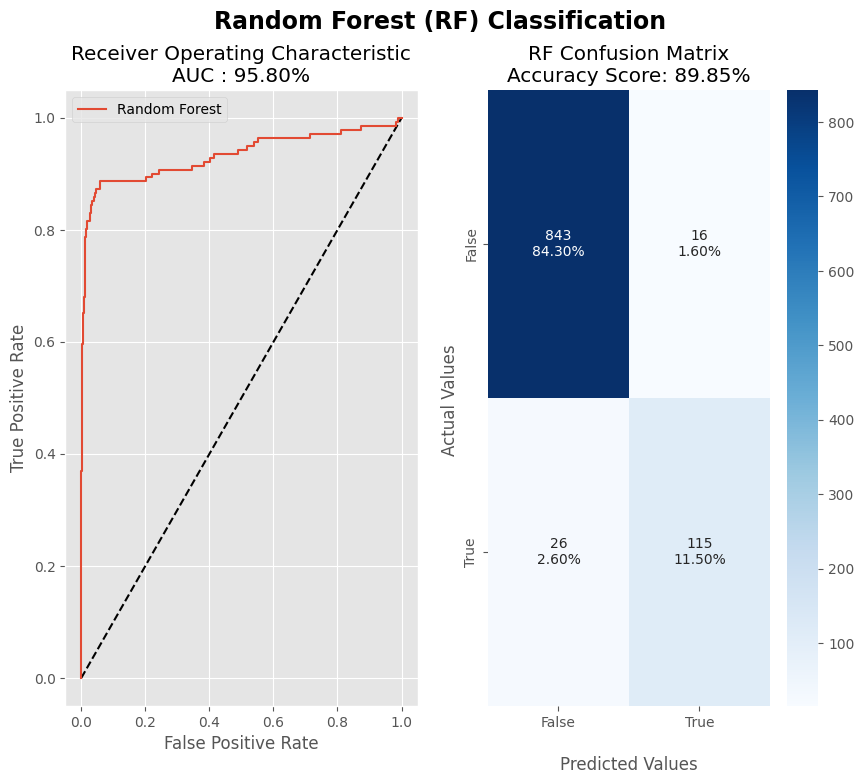

In [60]:
#Plot ROC curve and Confusion matrix
subplots_ROC_CM("Random Forest (RF) Classification",
                "Receiver Operating Characteristic",
                "RF Confusion Matrix",
                gridRf.best_estimator_,
                acmod_rf,
                aucmod_rf,
                conf_matrix_rf,
                "RF_y_test",
                X_test,
                y_test,
                "Random Forest")


### XGBoost

In [61]:
xgbc  = XGBClassifier(
    scale_pos_weight = neg / pos,
    eval_metric='logloss',
     random_state=seed
)

In [62]:
# Hyperparameter Tuning
parameters_xgbc = {
              'objective':['binary:logistic'],
              'learning_rate': [0.0001,0.001,0.01,0.1],
              'max_depth': [2,4,7,15],
              'subsample': [0.1,0.5,0.8],
              'colsample_bytree': [0.1,0.5,0.7],
              'n_estimators': [100,300,500,1000],
}

In [63]:
gridXgbc = GridSearchCV(xgbc, parameters_xgbc, cv=skfold)

In [64]:
y_xgbc_score = gridXgbc.fit(X_train, y_train)

In [65]:
gridXgbc.best_score_

np.float64(0.9582517299908605)

In [66]:
#best parameters
gridXgbc.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 15,
 'n_estimators': 500,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [67]:
best_estimator_grid_xgbc = gridXgbc.best_estimator_
best_estimator_grid_xgbc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [68]:
y_xgbc_pred = gridXgbc.predict(X_test)

In [69]:
report_xgbc = classification_report(y_test, y_xgbc_pred,output_dict=True)
df_report_xgbc = pd.DataFrame(report_xgbc).T
df_report_xgbc

,precision,recall,f1-score,support
0,0.969037,0.983702,0.976314,859.000
1,0.890625,0.808511,0.847584,141.000
accuracy,0.959000,0.959000,0.959000,0.959
macro avg,0.929831,0.896106,0.911949,1000.000
weighted avg,0.957981,0.959000,0.958163,1000.000


In [70]:
#Confusion matrix
conf_matrix_xgbc = confusion_matrix(y_test, y_xgbc_pred)
conf_matrix_xgbc

array([[845,  14],
       [ 27, 114]])

In [71]:
#Accuracy
acu_xgbc = accuracy_score(y_test, y_xgbc_pred)
acu_xgbc

0.959

In [72]:
#AUC
auc_xgbc = roc_auc_score(y_test, y_xgbc_pred)
auc_xgbc

np.float64(0.896106308671637)

In [73]:
acmod_xgbc = {"XGBC_y_test":round(acu_xgbc,4)}
aucmod_xgbc = {"XGBC_y_test":round(auc_xgbc,4)}

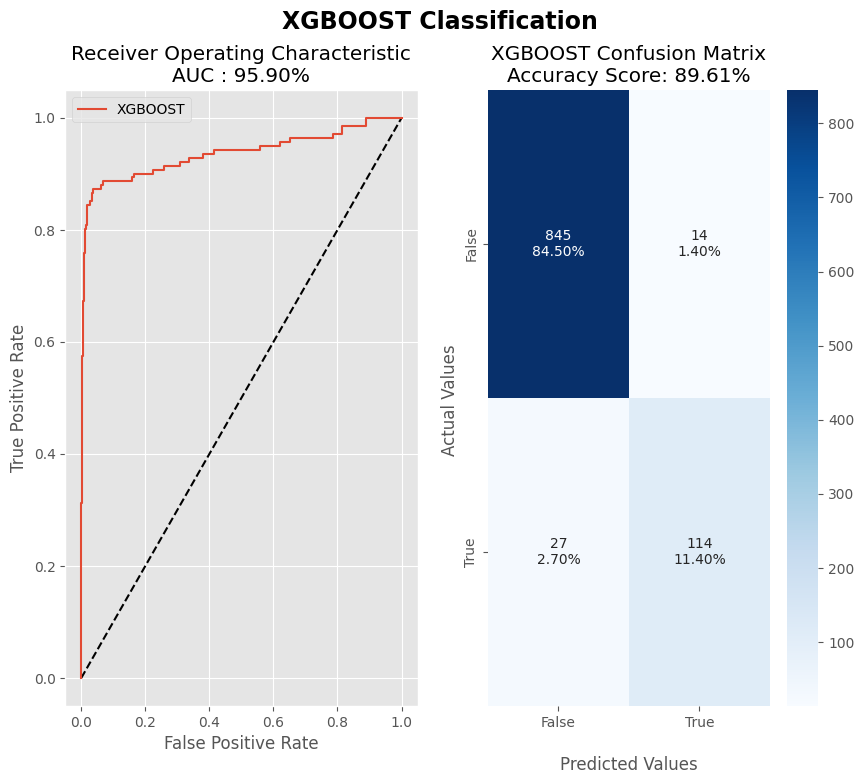

In [74]:
# Plot the ROC curve and confusion matrix
subplots_ROC_CM("XGBOOST Classification",
                "Receiver Operating Characteristic",
                "XGBOOST Confusion Matrix",
                gridXgbc.best_estimator_,
                acmod_xgbc,
                aucmod_xgbc,
                conf_matrix_xgbc,
                "XGBC_y_test",
                X_test,
                y_test,
                "XGBOOST")

### Model Selection

In [75]:
Accuracy = {"RF":acu_rf,"XGBC":acu_xgbc}
AUC = {"RF":auc_rf,"XGBC":auc_xgbc}
F1_score = {"RF":df_report_rf.iloc[3,2],
           "XGBC":df_report_xgbc.iloc[3,2]}

In [76]:
metrics_models = pd.DataFrame([Accuracy,AUC,F1_score],index=["Accuracy","AUC","F1"]).T
metrics_models

,Accuracy,AUC,F1
RF,0.958,0.898488,0.910641
XGBC,0.959,0.896106,0.911949


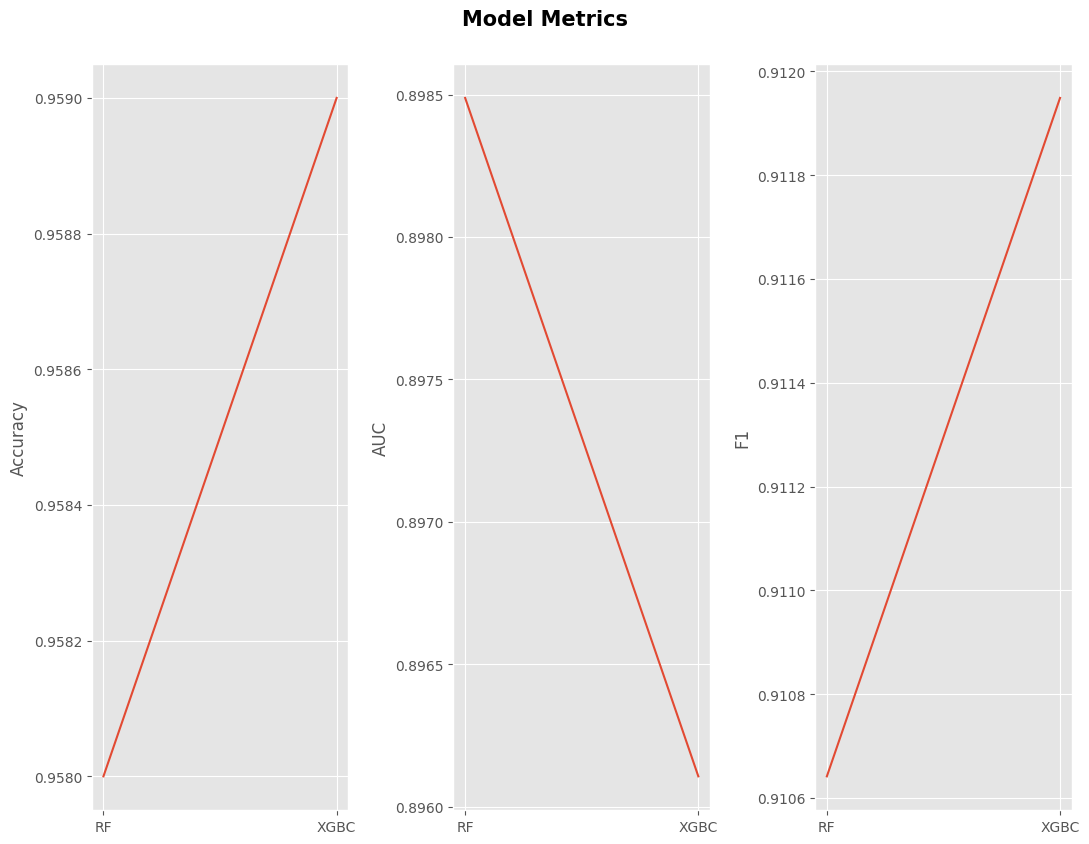

In [77]:
fig,axes= plt.subplots(1,3,figsize=(11,8))

for i,col in enumerate(metrics_models.columns):
    sns.lineplot(data=metrics_models[col],ax=axes[i] )

plt.tight_layout()
plt.suptitle("Model Metrics", fontsize = 15, fontweight = "bold", y=1.05)
plt.savefig('model_metrics.png',bbox_inches='tight')
plt.show()

In [78]:
false_Negative = [conf_matrix_rf[1,0],
                 conf_matrix_xgbc[1,0]]
false_Negative_S = pd.Series(false_Negative,name="FN",index=["RF","XGBC"])

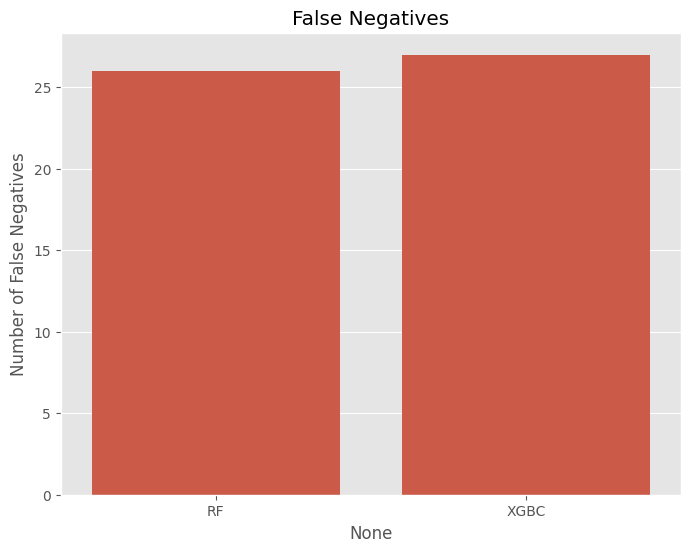

In [79]:
fig  = plt.figure(figsize=(8, 6))
sns.barplot(x=false_Negative_S.index,y=false_Negative_S.values)
plt.ylabel("Number of False Negatives")
plt.title("False Negatives")
plt.savefig('false_negatives.png',bbox_inches='tight')
plt.show()

# Business Case

* **Understanding the key characteristics of customers who are likely to churn.**

| Rank | Feature                        | Importance (%) |
|------|--------------------------------|----------------|
| 1    | international_plan             | 35.16          |
| 2    | number_customer_service_calls  | 19.15          |
| 3    | voice_mail_plan                | 11.18          |
| 4    | total_day_minutes              | 9.98           |
| 5    | total_eve_charge               | 7.89           |
| 6    | total_intl_minutes             | 6.94           |
| 7    | total_eve_minutes              | 5.76           |
| 8    | total_intl_calls               | 5.32           |


* Predicting the customer’s likelihood of leaving (churning).

In [103]:
customer_ids = df['phone_number']

# encode the categorical values
enc = ce.TargetEncoder(cols=cat_cols,smoothing=11).fit(X[cat_cols],y)
X[cat_cols] = enc.transform(X[cat_cols])
X[X.columns] = scaler.fit_transform(X)
proba_churn = gridRf.predict_proba(X)[:,1]

In [104]:
df_results = pd.DataFrame({
    'phone_number': customer_ids,
    'churn_proba': proba_churn,
    'Churn':y
})
df_results

,phone_number,churn_proba,Churn
0,382-4657,0.043411,0
1,371-7191,0.046683,0
2,358-1921,0.036385,0
3,375-9999,0.258140,0
4,330-6626,0.064609,0
...,...,...,...
4995,365-8751,0.157713,0
4996,334-9736,0.648477,1
4997,333-6861,0.022890,0
4998,394-2206,0.022811,0


In [121]:
df_results.to_csv('/content/drive/MyDrive/Francisco_Regalado/data/predictions/all_predictions.csv',
                  index=False)

* Identifying the top 500 customers to contact first – maximizing profitability and minimizing churn.


In [102]:
top_500 = df_results.sort_values('churn_proba', ascending=False).head(500)
top_500

,phone_number,churn_proba,Churn
2696,359-6232,0.999339,1
2388,343-2592,0.999266,1
2099,419-5171,0.999226,1
2038,335-4888,0.999202,1
3993,406-2551,0.999090,1
...,...,...,...
2147,387-1535,0.839796,1
3546,329-4592,0.839636,1
509,397-9148,0.839200,1
1862,379-1720,0.838263,1


In [122]:
top_500.to_csv('/content/drive/MyDrive/Francisco_Regalado/data/predictions/top500_predictions.csv',
                  index=False)

* Evaluating how your strategy compares to randomly contacting the business’ customers.

In [130]:
# Number of clients
N = 500

# ML strategy
top_model = df_results.sort_values('churn_proba', ascending=False).head(N)
churners_model = top_model['Churn'].sum()
print(f"Churners captured by model: {churners_model} / {N}")

# Random strategy
top_random = df.sample(N, random_state=seed)
churners_random = top_random['Churn'].sum()
print(f"Churners captured by random: {churners_random} / {N}")

# Lift
lift = churners_model / churners_random
print(f"Lift over random: {lift:.2f}x")

Churners captured by model: 500 / 500
Churners captured by random: 71 / 500
Lift over random: 7.04x


The model provides an efficient and targeted retention strategy, allowing the company to focus its resources on customers most likely to churn, improving the impact of retention compared to a random approach.

Demonstrating that the churn model is seven times more effective than selecting customers at random, making it a more efficient strategy.